In [1]:
import matplotlib
#matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# choose start data and end data of this trip
start_date = "2018-04-01"
end_date = "2018-04-10"

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False) 

In [5]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [6]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys() # all classes in base

['measurements', 'stations']

In [7]:
session = Session(engine)

In [8]:
# save a reference to the classes
Measurement = Base.classes.measurements
Station = Base.classes.stations

## Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and prcp values.
* Load the query results into a Pandas DataFrame and set the index to the date column.
* Plot the results using the DataFrame plot method.
* Use Pandas to print the summary statistics for the precipitation data.

In [9]:
# latest date of the measurement table as the last day of the 12 month
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [10]:
last_12m = '2017-08-23'
first_12m = '2016-08-23'

In [11]:
# query to retrieve the last 12 months of precipitation data
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= first_12m).\
    order_by(Measurement.date).all()
df_prcp = pd.DataFrame(prcp)

# set index to date column
df_prcp = df_prcp.set_index('date')
df_prcp.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


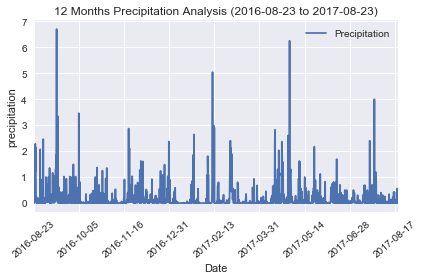

In [12]:
df_prcp.plot()
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.title("12 Months Precipitation Analysis (2016-08-23 to 2017-08-23)")
plt.legend(["Precipitation"],loc=1)
plt.xticks(rotation=40)
plt.tight_layout()
#plt.figure(figsize=(9,3))
plt.savefig("12m_prcp.png")
plt.show()

In [13]:
# summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

* Design a query to calculate the total number of stations.


* Design a query to find the most active stations.
  + List the stations and observation counts in descending order
  + Which station has the highest number of observations?


* Design a query to retrieve the last 12 months of temperature observation data (tobs).
  + Filter by the station with the highest number of observations.
  + Plot the results as a histogram with bins=12.

In [14]:
# count the total number of stations
session.query(func.count(Measurement.station.distinct())).all()

[(9)]

In [15]:
station_obs = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()
station_obs
# station USC00519281 has the highest number of observations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [16]:
# staition has the highest number of observations
station_high = station_obs[0][0]
station_high

'USC00519281'

In [17]:
tobs = session.query(Measurement.station,Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= first_12m).\
    filter(Measurement.station == station_high).\
    order_by(Measurement.date).all()

df_tobs = pd.DataFrame(tobs)
df_tobs.set_index("date")
df_tobs.head()

,station,date,tobs
0,USC00519281,2016-08-23,77
1,USC00519281,2016-08-24,77
2,USC00519281,2016-08-25,80
3,USC00519281,2016-08-26,80
4,USC00519281,2016-08-27,75


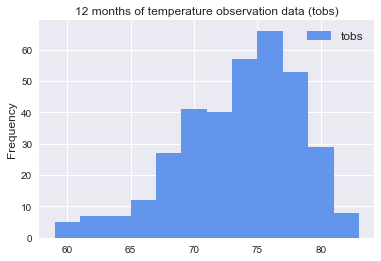

In [18]:
plt.hist(df_tobs['tobs'],12,color="cornflowerblue")
plt.ylabel("Frequency",fontsize=12)
plt.title("12 months of temperature observation data (tobs)")
plt.legend(["tobs"],loc=1,fontsize=12)
plt.show()

## Temperature Analysis


* Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.


* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")


* Plot the min, avg, and max temperature from your previous query as a bar chart.
  + Use the average temperature as the bar height.
  + Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [19]:
# accept a start date and end date in the format %Y-%m-%d and return the minimum, 
# average, and maximum temperatures for that range of dates
def calc_temps(start_date,end_date):
    return(session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                        filter(Measurement.date >= start_date).\
                        filter(Measurement.date <= end_date).all())

calc_temps("2017-01-01","2017-03-01")

[(59, 69.53097345132744, 80)]

In [20]:
start_date_lastyear = start_date.replace("2018","2017")
end_date_lastyear = end_date.replace("2018","2017")
[start_date_lastyear,end_date_lastyear] # trip start and end date of previous year

['2017-04-01', '2017-04-10']

In [21]:
trip = calc_temps(start_date_lastyear,end_date_lastyear)
trip

[(67, 74.32758620689656, 80)]

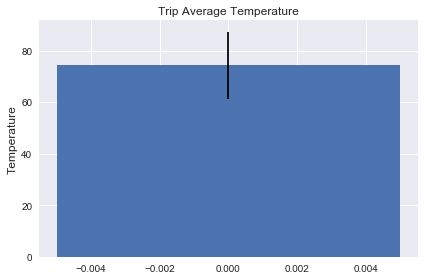

In [22]:
yerr = float(trip[0][0])-float(trip[0][2])
plt.bar(np.arange(1),float(trip[0][1]),width=0.01,yerr=yerr)
plt.ylabel("Temperature",fontsize=12)
plt.title('Trip Average Temperature',fontsize=12)
plt.tight_layout()
plt.show() #Plot the min, avg, and max temperature from your previous query as a bar chart.